# Practical Bayesian Optimization

The purpose of this notebook is to demonstrate a few feature engineering techniques that use only latitude and longitude.

## 0. Env

#### Imports

In [37]:
import os
import time
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
pl.Config.set_fmt_str_lengths(90)

polars.config.Config

#### Constants

In [4]:
home = "../.."
images_dir = os.path.join(home, "static/images/")

In [3]:
TRAIN_TEST_SPLIT_FRACTION = 0.8
MODEL_TARGET = "price_log10"

## 1. Load Data

#### Load data for New York City

In [4]:
df_query = (
    pl.scan_csv("../data/miami-housing.csv")
    .with_columns([
        pl.col("SALE_PRC").alias("price"),
        pl.col(["LATITUDE", "LONGITUDE"]).name.to_lowercase()
    ])
    .select(pl.col(["latitude", "longitude", "price"]))
    .with_columns((pl.col("price")).log10().name.suffix("_log10"))
)

In [6]:
num_rows = df_query.collect().shape[0]
df = (
    df_query.collect()
    .sample(fraction=1, shuffle=True)
    .with_row_index(name="row_number")
    .with_columns([
        (pl.col("row_number") < TRAIN_TEST_SPLIT_FRACTION * num_rows).alias("is_train")
    ])
)

#### Viewing the data

In [25]:
display(df.count())

row_number,latitude,longitude,price,price_log10,is_train
u32,u32,u32,u32,u32,u32
13932,13932,13932,13932,13932,13932


In [7]:
display(
    df
    .head()
)

row_number,latitude,longitude,price,price_log10,is_train
u32,f64,f64,f64,f64,bool
0,25.767182,-80.27441,255000.0,5.40654,true
1,25.633533,-80.353072,750000.0,5.875061,true
2,25.656819,-80.33282,1.35e6,6.130334,true
3,25.567167,-80.356046,255000.0,5.40654,true
4,25.465031,-80.422861,313000.0,5.495544,true


## 2. Brief EDA

#### Distribution of Prices

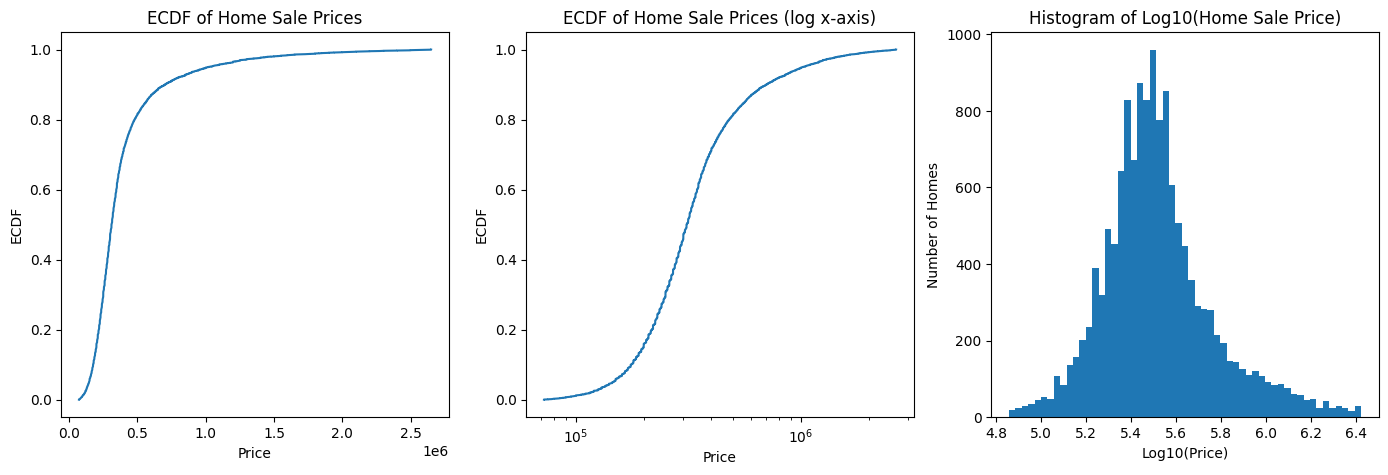

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax1.set_xlabel("Price")
ax1.set_ylabel("ECDF")
ax1.set_title("ECDF of Home Sale Prices")

ax2.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax2.set_xscale("log")
ax2.set_xlabel("Price")
ax2.set_ylabel("ECDF")
ax2.set_title("ECDF of Home Sale Prices (log x-axis)")

ax3.hist(df["price_log10"], bins=55, density=False)
ax3.set_xlabel("Log10(Price)")
ax3.set_ylabel("Number of Homes")
ax3.set_title("Histogram of Log10(Home Sale Price)")

plt.savefig(os.path.join(images_dir, "distribution-of-home-sale-price.png"))

#### Distribution over Space

In [13]:
df.select(["latitude", "longitude", "price"]).corr()

latitude,longitude,price
f64,f64,f64
1.0,0.721232,0.047701
0.721232,1.0,0.195274
0.047701,0.195274,1.0


## 3. Hyperparameter Optimization

### 3.0 Setup

In [12]:
MODEL_PERFORMANCE_LIST = []

In [13]:
X_train = df.filter(pl.col("is_train"))
y_train = df.filter(pl.col("is_train"))
X_test = df.filter(~pl.col("is_train"))
y_test = df.filter(~pl.col("is_train"))

In [31]:
n_estimators_hp_space = [5, 50, 75, 100, 125, 150, 200, 500, 1000, 2000, 3000]

In [32]:
MODEL_FEATURE_LIST_NAME = "raw_lat_lon"
MODEL_FEATURE_LIST = ["latitude", "longitude"]

### 3.1. Dummy

In [39]:
for n_estimators in n_estimators_hp_space:
    t_start = time.time()
    model = (
        LGBMRegressor(
            n_estimators=n_estimators,
            force_col_wise=True,
            verbosity=0,
        )
        .fit(
            X_train.select(MODEL_FEATURE_LIST),
            y_train.select(MODEL_TARGET).to_series()
        )
    )
    y_predicted = model.predict(X_test.select(MODEL_FEATURE_LIST))
    model_performance = root_mean_squared_error(y_test.select(MODEL_TARGET).to_series(), y_predicted)
    t_end = time.time()
    duration = t_end - t_start
    
    print(n_estimators, f"{model_performance:.04f}", f"{duration:.04f}")

5 0.1863 0.0144
50 0.1203 0.0385
75 0.1166 0.0373
100 0.1149 0.0441
125 0.1133 0.0536
150 0.1121 0.0709
200 0.1106 0.0868
500 0.1075 0.1930
1000 0.1064 0.3832
2000 0.1070 0.7737
3000 0.1078 1.1385


### 3.2. Bayes Optimization

In [68]:
def plot_prediction_surface(grid, y_mean, y_std):
    plt.plot(grid, y_mean, "r")
    plt.plot(grid, y_mean - y_std, "b")
    plt.plot(grid, y_mean + y_std, "b")
    plt.show()

100 0.1149 0.0704


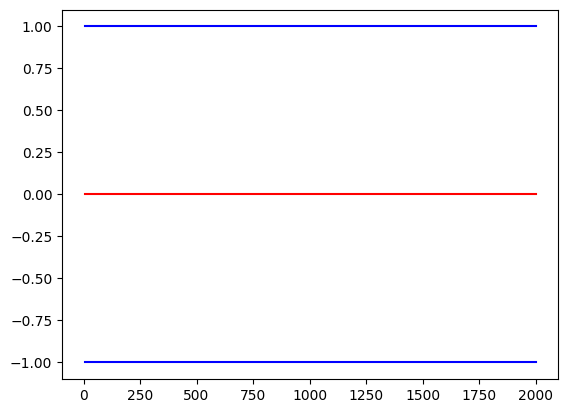

105 0.1146 0.0541


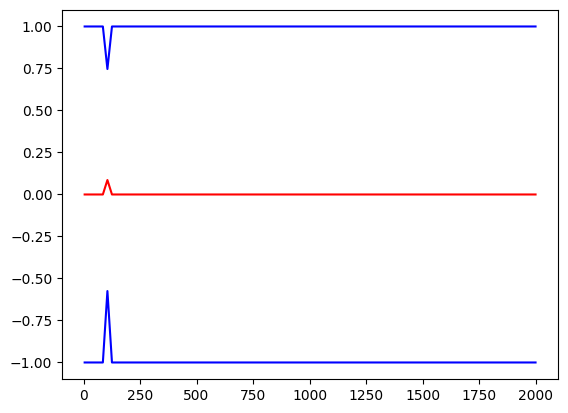

5 0.1863 0.0120


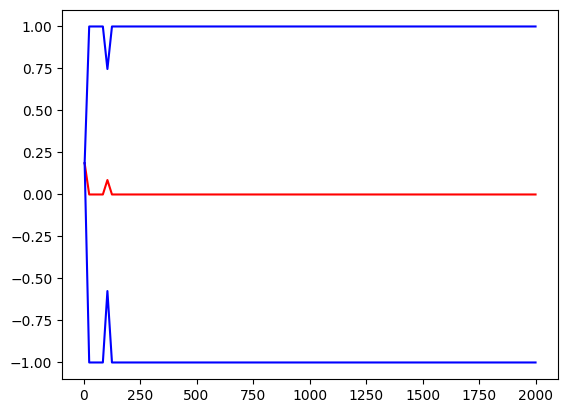

25 0.1293 0.0216


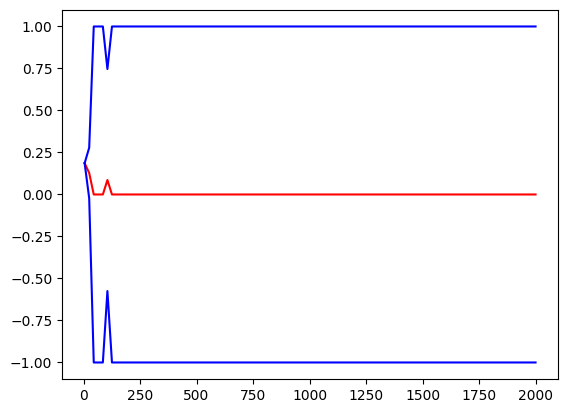

45 0.1213 0.0313


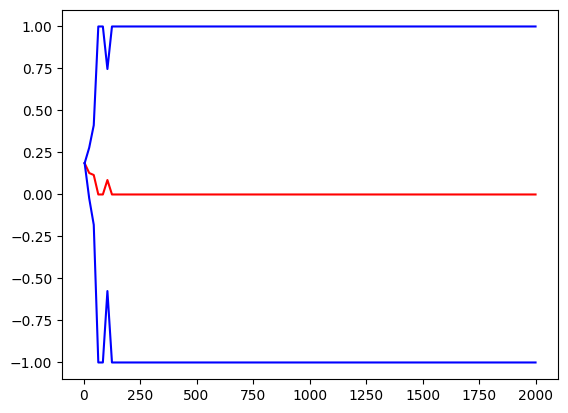

65 0.1179 0.0467


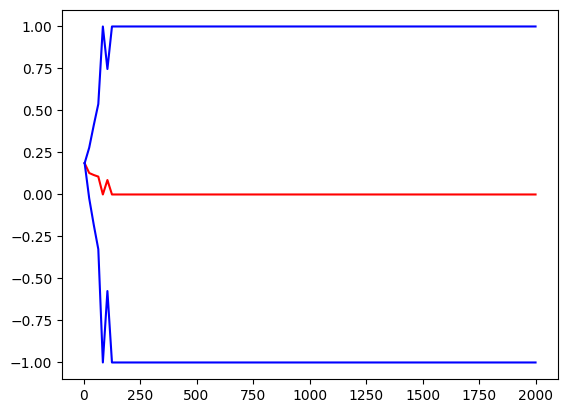

85 0.1158 0.0502


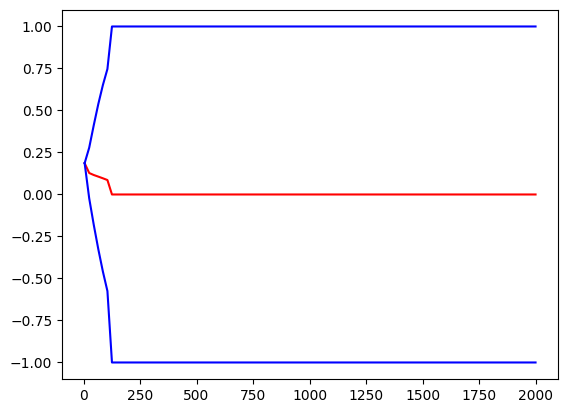

125 0.1133 0.0664


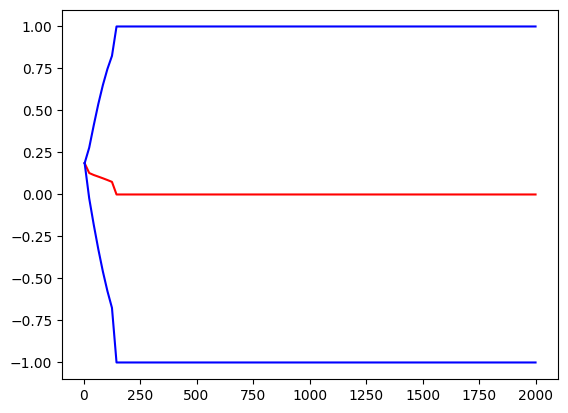

146 0.1123 0.0766


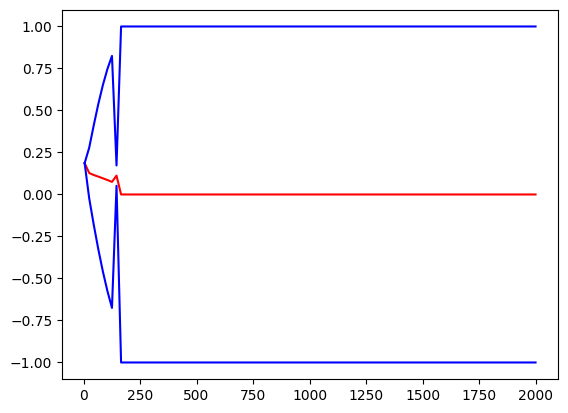

166 0.1116 0.0903


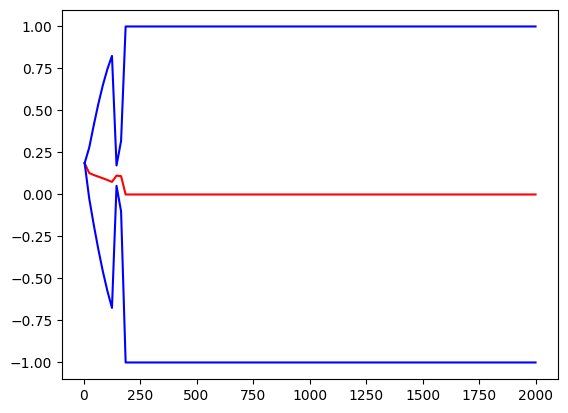

186 0.1110 0.0883


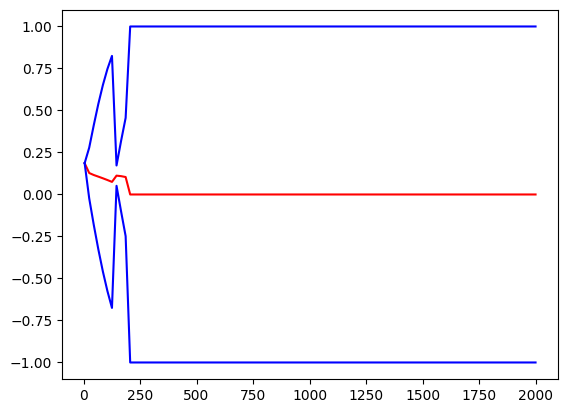

206 0.1105 0.0989


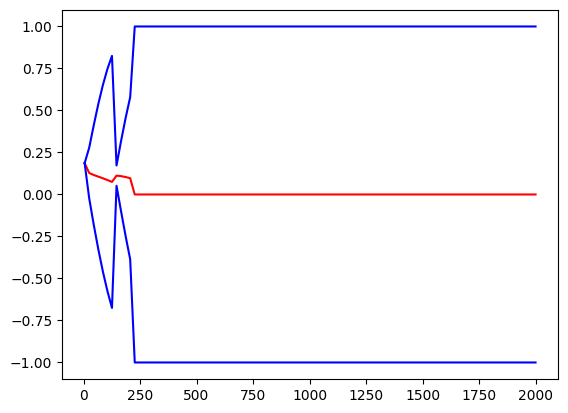

226 0.1100 0.1056


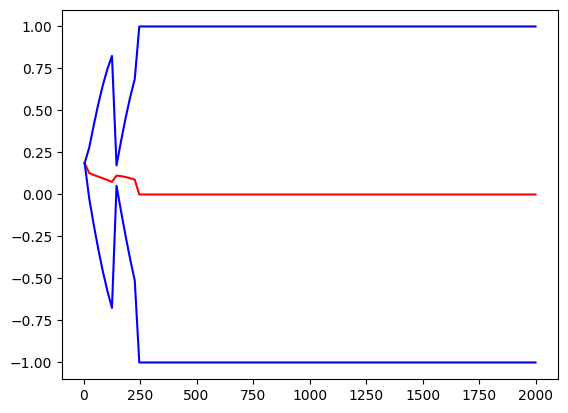

246 0.1096 0.1051


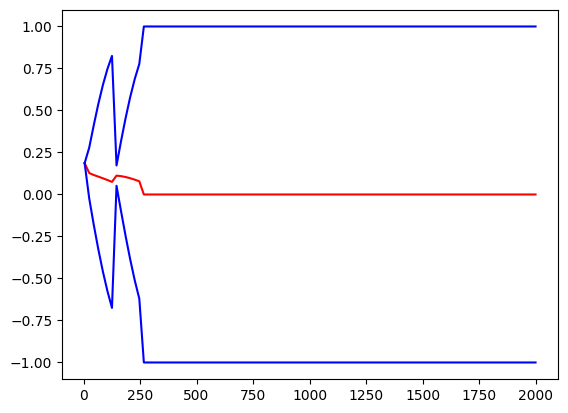

266 0.1094 0.1129


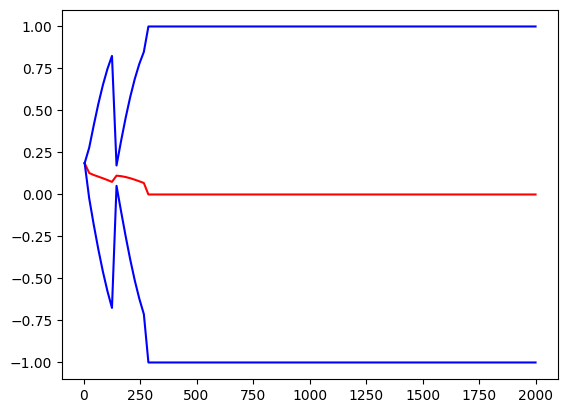

287 0.1091 0.1320


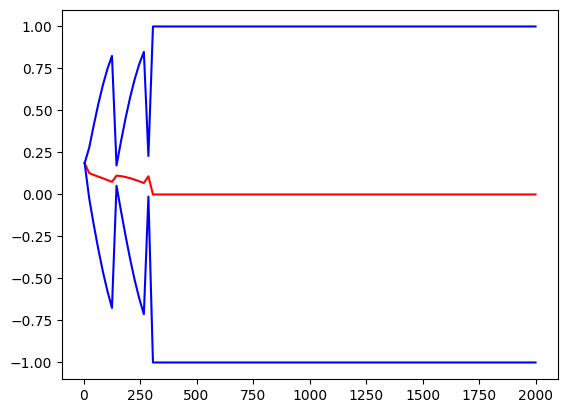

307 0.1089 0.1402


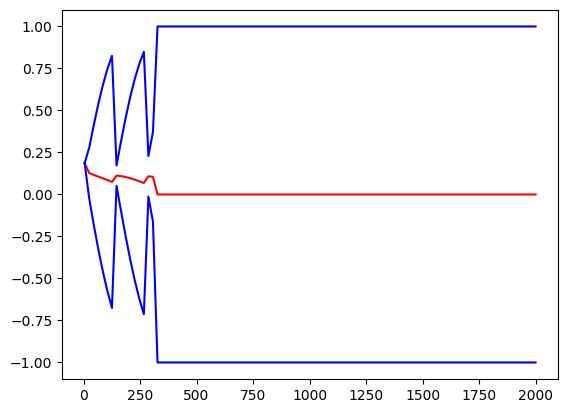

327 0.1087 0.1436


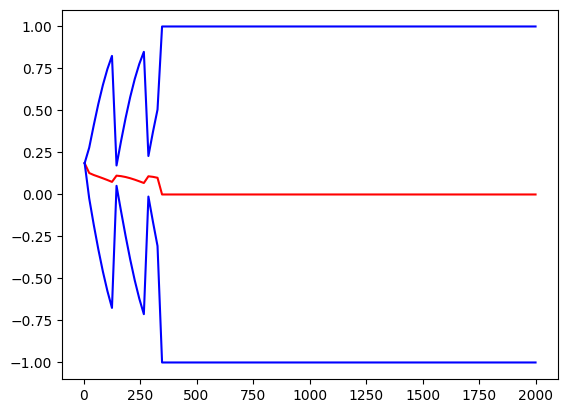

347 0.1085 0.1581


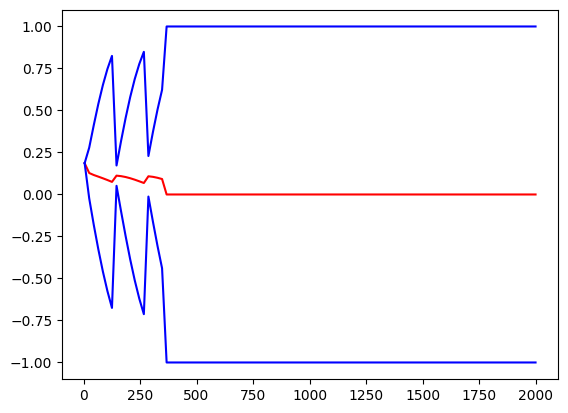

367 0.1084 0.1590


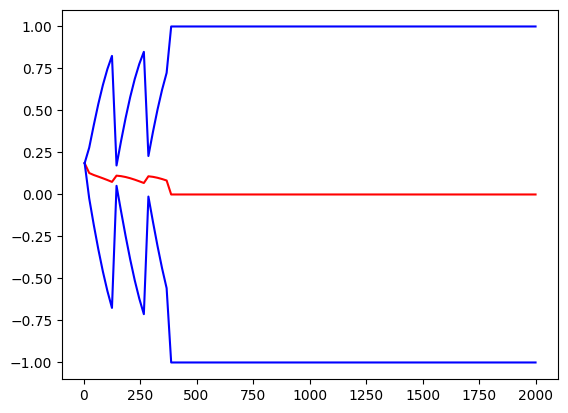

387 0.1083 0.1756


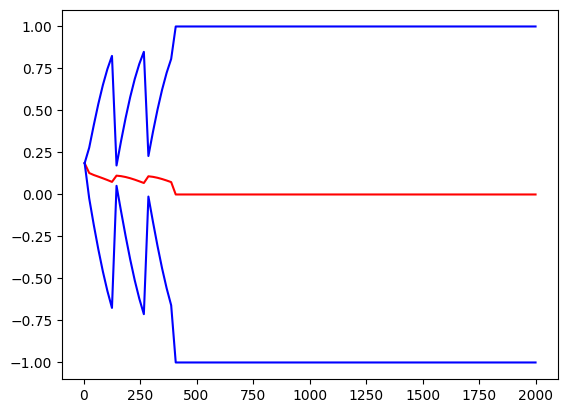

408 0.1082 0.1810


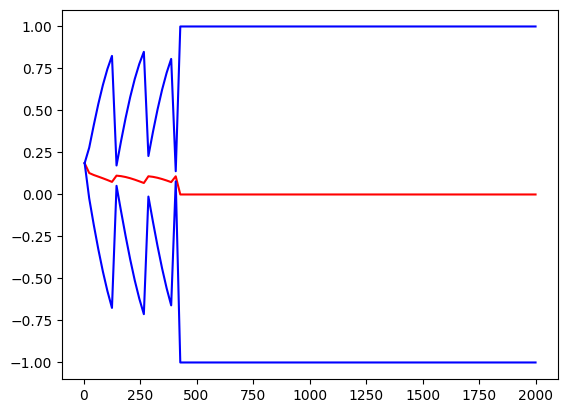

428 0.1080 0.1895


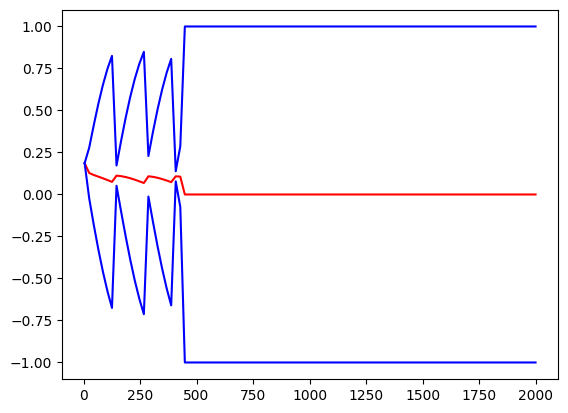

448 0.1079 0.2039


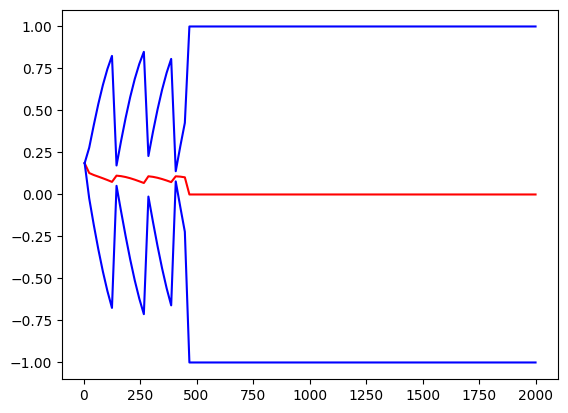

468 0.1077 0.2060


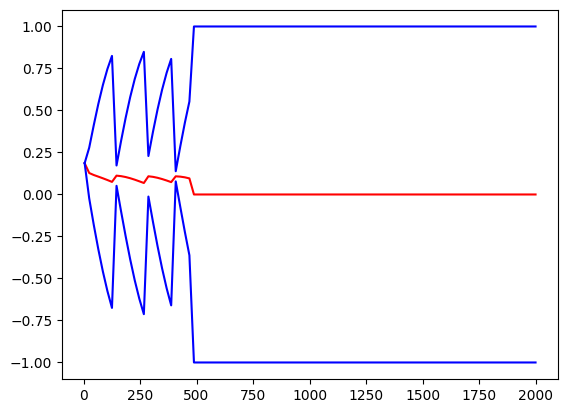

488 0.1076 0.2169


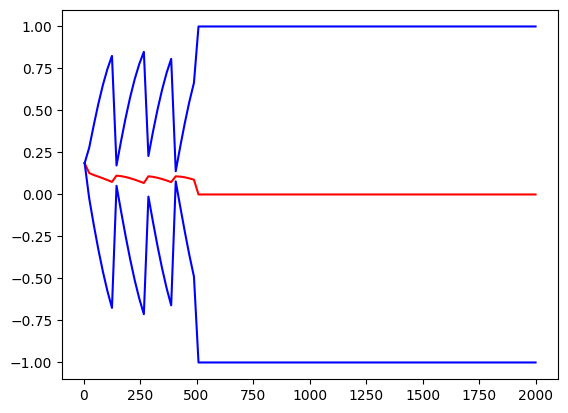

508 0.1075 0.2224


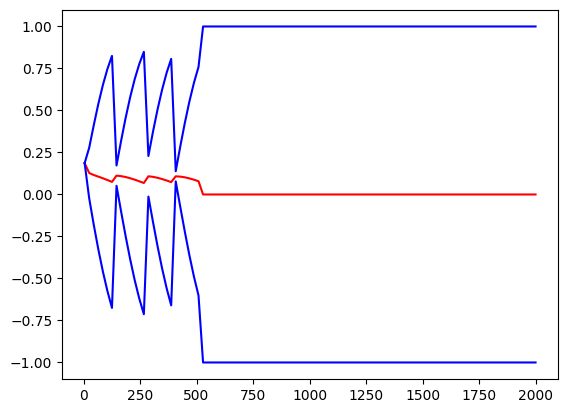

528 0.1074 0.2348


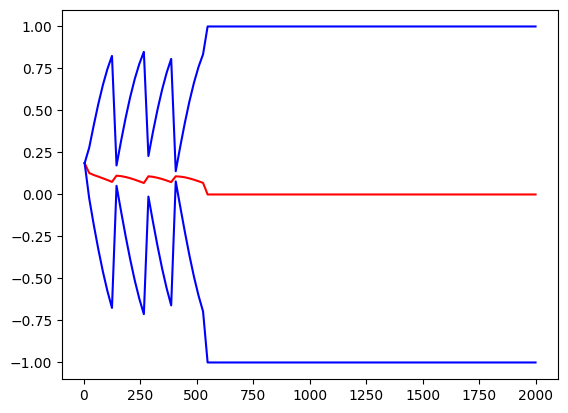

549 0.1073 0.2502


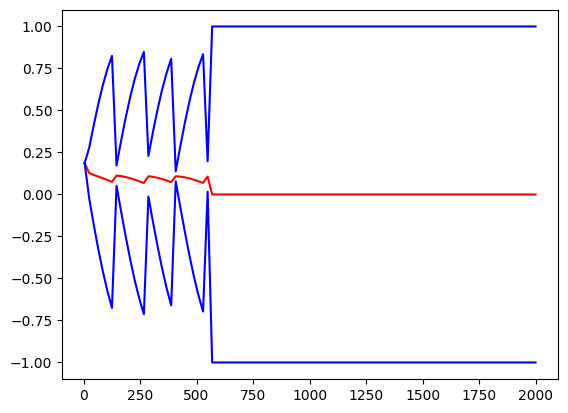

569 0.1073 0.2715


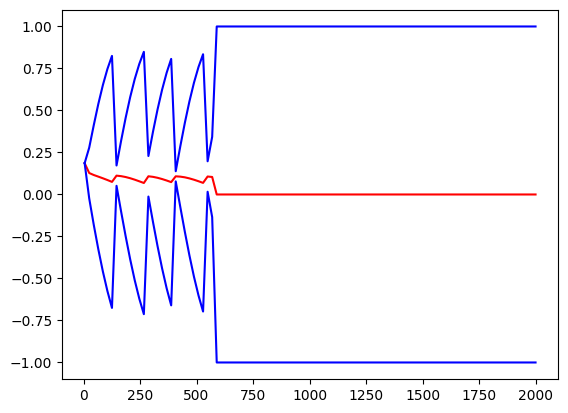

589 0.1072 0.2607


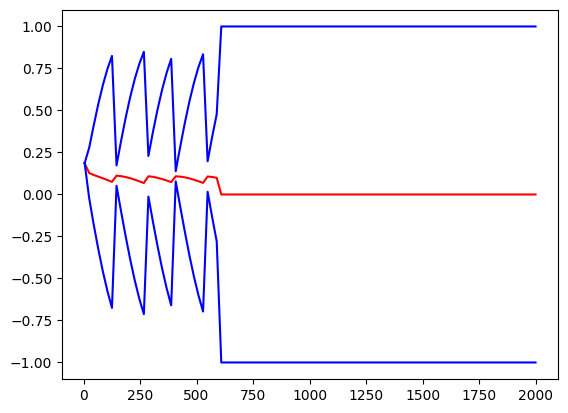

609 0.1071 0.3001


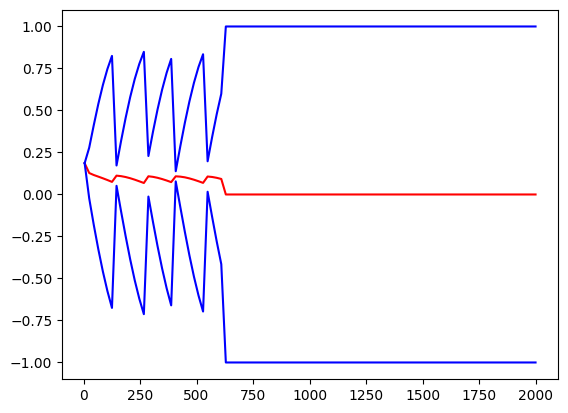

629 0.1070 0.2656


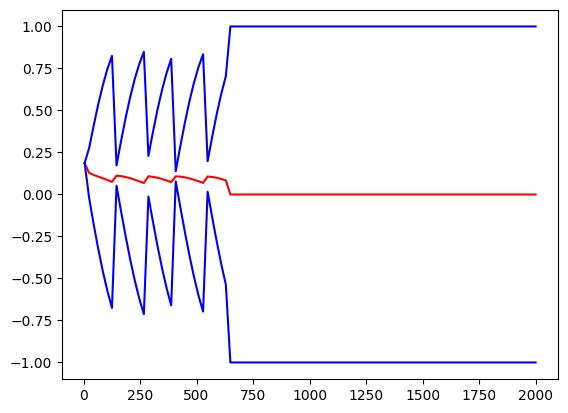

649 0.1069 0.2880


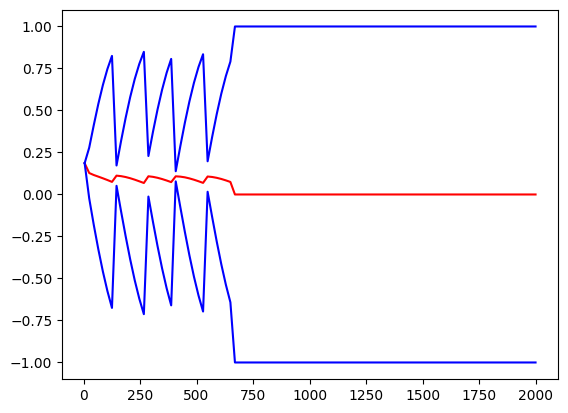

670 0.1069 0.3204


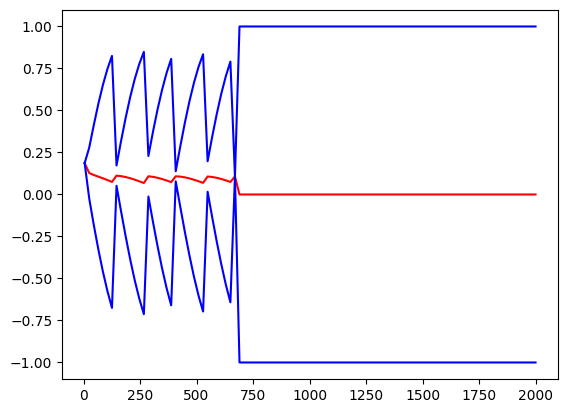

690 0.1068 0.3096


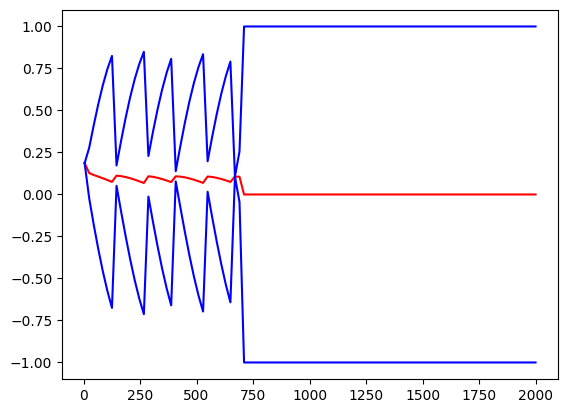

710 0.1067 0.3124


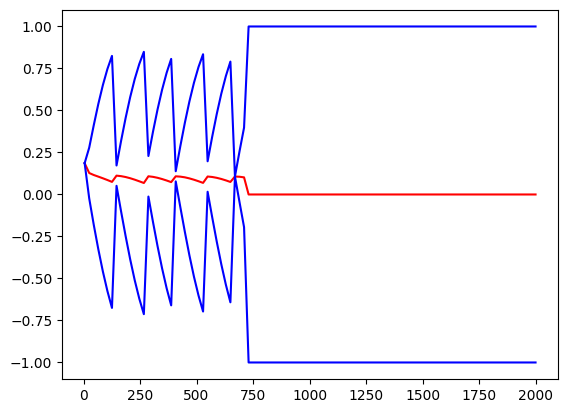

730 0.1066 0.3267


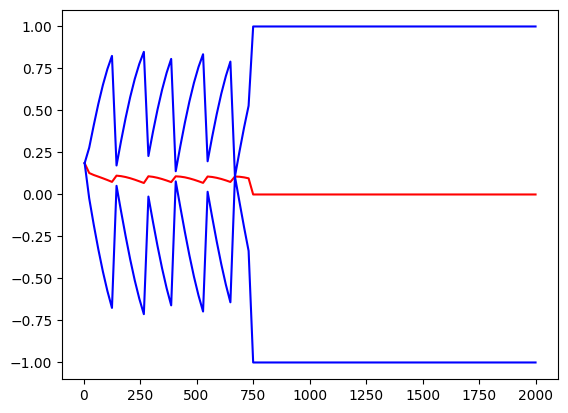

750 0.1066 0.3513


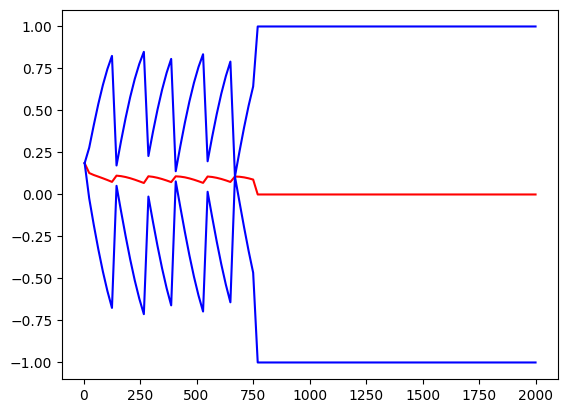

770 0.1066 0.3603


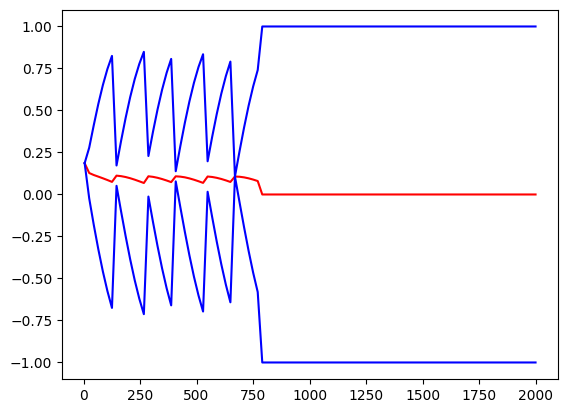

790 0.1066 0.3589


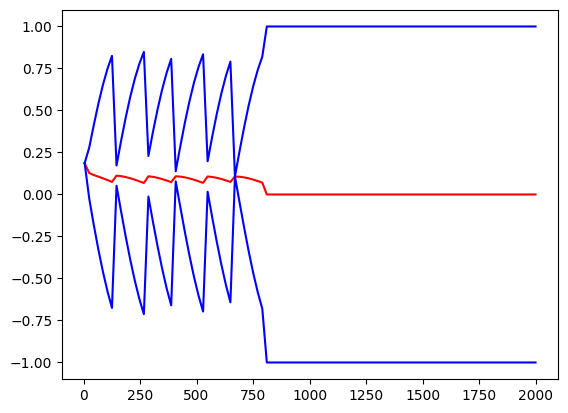

811 0.1066 0.3616


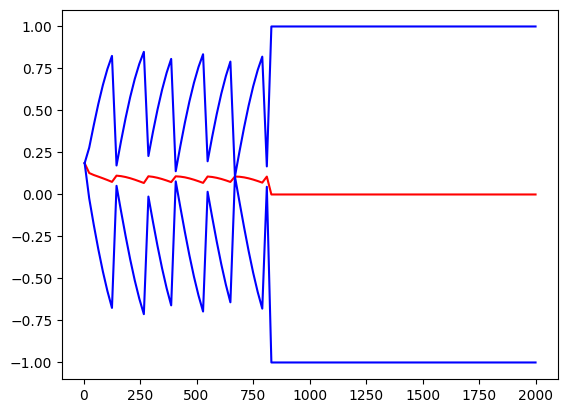

831 0.1066 0.3811


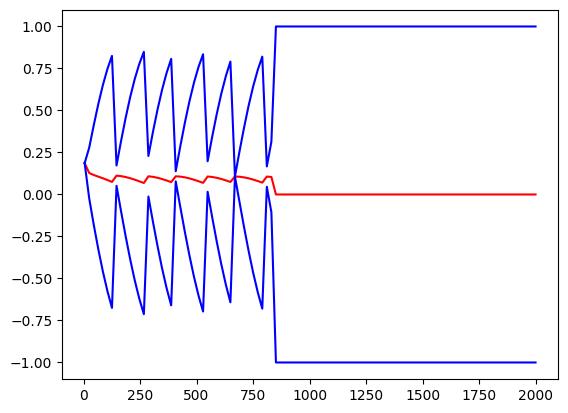

851 0.1066 0.3907


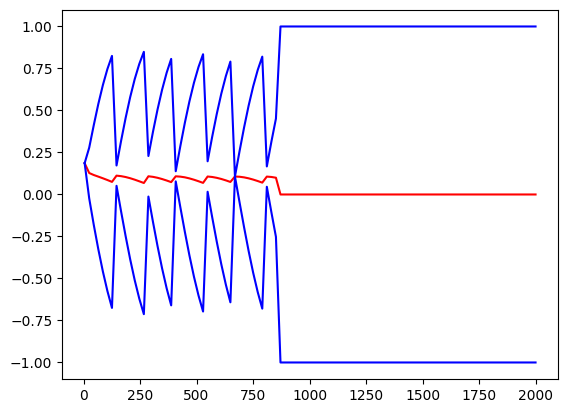

871 0.1065 0.4041


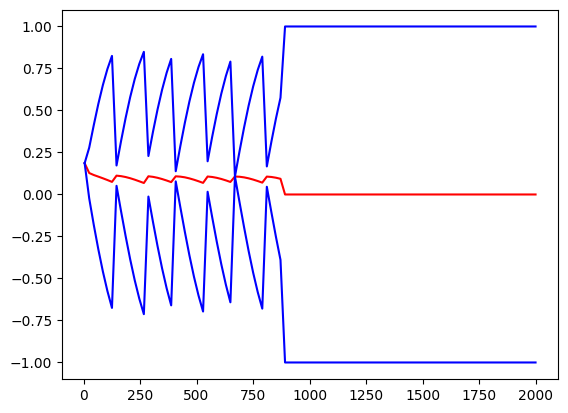

891 0.1066 0.3630


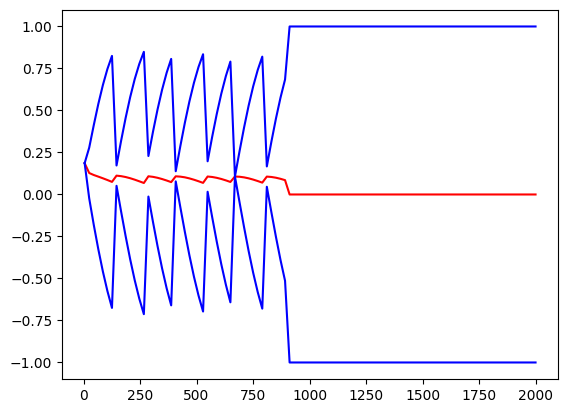

911 0.1065 0.4302


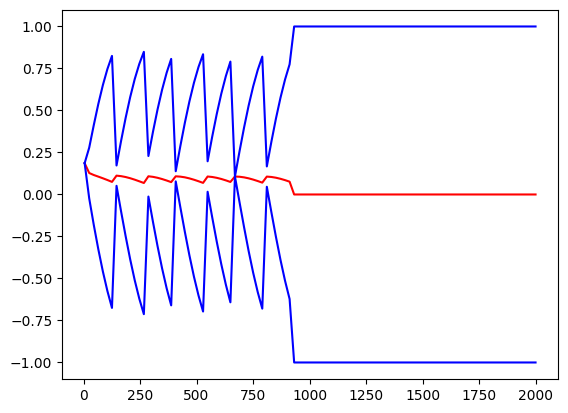

931 0.1065 0.4065


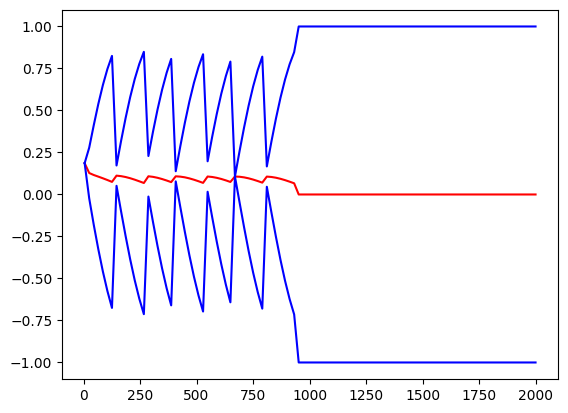

952 0.1065 0.3953


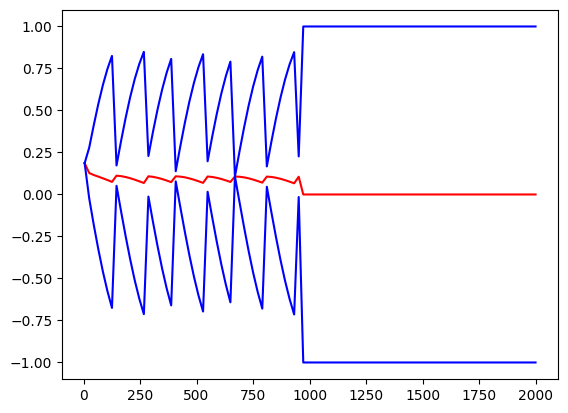

972 0.1064 0.4486


In [71]:
bayesian_optimizer = GaussianProcessRegressor()

explore_exploit = .5

n_estimators_hp_range = [5, 2000]
grid_resolution = 100
n_estimators_grid = np.linspace(*n_estimators_hp_range, grid_resolution).reshape(-1, 1)

n_estimators_init = 100
n_estimators_attempts = [[500]]
n_estimators_performances = [.1075]

for run_number in range(50):

    # init_case
    if run_number == 0:
        n_estimators = n_estimators_init
    else:
        grid_predicted_mean, grid_predicted_std = bayesian_optimizer.predict(n_estimators_grid, return_std=True)
        acquisition_function = explore_exploit * grid_predicted_mean + (1 - explore_exploit) * grid_predicted_std
        next_best_n_estimators = n_estimators_grid[acquisition_function.argmax()]
        n_estimators = int(next_best_n_estimators)
        plot_prediction_surface(n_estimators_grid, grid_predicted_mean, grid_predicted_std)
    
    # predict
    t_start = time.time()
    model = (
        LGBMRegressor(
            n_estimators=n_estimators,
            force_col_wise=True,
            verbosity=0,
        )
        .fit(
            X_train.select(MODEL_FEATURE_LIST),
            y_train.select(MODEL_TARGET).to_series()
        )
    )
    y_predicted = model.predict(X_test.select(MODEL_FEATURE_LIST))
    model_performance = root_mean_squared_error(y_test.select(MODEL_TARGET).to_series(), y_predicted)
    t_end = time.time()
    duration = t_end - t_start
    print(n_estimators, f"{model_performance:.04f}", f"{duration:.04f}")
    
    # fit bayesian optimizer
    n_estimators_attempts.append([n_estimators])
    n_estimators_performances.append(model_performance)
    bayesian_optimizer.fit(n_estimators_attempts, n_estimators_performances)